In [119]:
import sframe                                                  # see below for install instruction
import numpy as np                                             # dense matrices
import matplotlib.pyplot as plt                                # plotting
from scipy.stats import multivariate_normal                    # multivariate Gaussian distribution
import copy                                                    # deep copies

%matplotlib inline

In [120]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal 
        #  to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [121]:
# Model parameters
init_means = np.array([
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
])
init_covariances = np.array([
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
])
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

In [122]:
init_covariances

array([[[ 0.5 ,  0.  ],
        [ 0.  ,  0.5 ]],

       [[ 0.92,  0.38],
        [ 0.38,  0.91]],

       [[ 0.5 ,  0.  ],
        [ 0.  ,  0.5 ]]])

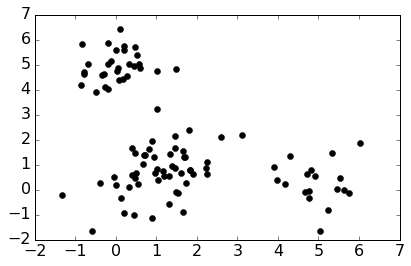

In [123]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [124]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))


def loglikelihood(data,weights,means,covs):
    num_clusters = len(means)
    num_dim = len(data[0])
    ll = 0
    for d in data:
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            delta = np.array(d) - means[k]
            sigmaInv = np.linalg.inv(covs[k])
            exponent_term = np.dot(delta.T,np.dot(sigmaInv,delta))
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        ll += log_sum_exp(Z)
        
    return ll

In [125]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in range(maxiter):
        if i % 5 == 0:
            print("Iteration %s" % i)
        
        # E-step: compute responsibilities
        # Update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j.
        # Hint: To compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf.
        for j in range(num_data):
            for k in range(num_clusters):
                
                resp[j, k] = weights[k]*multivariate_normal.pdf(data[j],means[k],covariances[k])
                
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums # normalize over all possible cluster assignments

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = np.sum(resp, axis=0)
        
        for k in range(num_clusters):
            
            # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
            # YOUR CODE HERE
            weights[k] = counts[k]/num_data
            
            # Update means for cluster k using the M-step update rule for the mean variables.
            # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
            weighted_sum = np.zeros(num_dim)
            for j in range(num_data):
                # YOUR CODE HERE
                weighted_sum += (resp[j,k] * data[j])
            # YOUR CODE HERE
            means[k] = weighted_sum/counts[k]
            
            # Update covariances for cluster k using the M-step update rule for covariance variables.
            # This will assign the variable covariances[k] to be the estimate for \hat{Sigma}_k.
            weighted_sum = np.zeros((num_dim, num_dim))
            for j in range(num_data):
                # YOUR CODE HERE (Hint: Use np.outer on the data[j] and this cluster's mean)
                
                delta = data[j]-means[k]
                weighted_sum += (resp[j,k]*np.outer(delta,delta))
            # YOUR CODE HERE
            covariances[k] = weighted_sum/counts[k]
          
        
        # Compute the loglikelihood at this iteration
        # YOUR CODE HERE
        ll_latest = loglikelihood(data,weights,means,covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if i % 5 != 0:
        print("Iteration %s" % i)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [126]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = np.array([data[x] for x in chosen])
initial_covs = np.array([np.cov(data, rowvar=0)] * 3)
initial_weights = np.array([1/3.] * 3)

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


In [127]:
results['weights']

array([ 0.30071023,  0.1799371 ,  0.51935267])

In [128]:
results['means']

array([[ 0.02138285,  4.947729  ],
       [ 4.94239235,  0.31365311],
       [ 1.08181125,  0.73903508]])

In [129]:
results['covs']

array([[[ 0.2932614 ,  0.05048455],
        [ 0.05048455,  0.35281537]],

       [[ 0.3556437 , -0.01494875],
        [-0.01494875,  0.66695025]],

       [[ 0.67114992,  0.33058965],
        [ 0.33058965,  0.90429724]]])

In [130]:
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

Iteration 0
Iteration 0


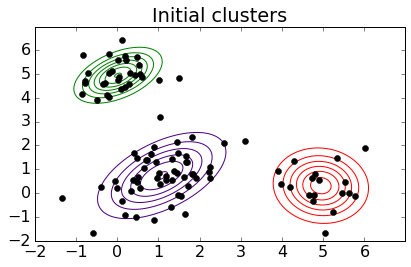

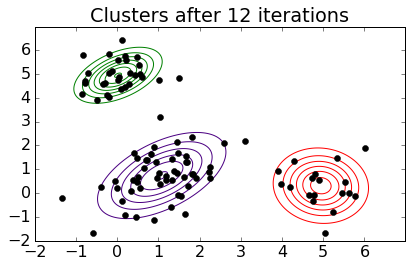

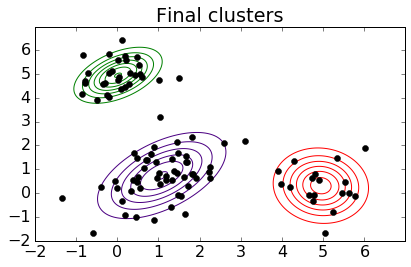

In [131]:
# Parameters after initialization
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

# Parameters after 12 iterations
results = EM(data, initial_means, initial_covs, initial_weights,maxiter=12)
plot_contours(data, results['means'], results['covs'], 'Clusters after 12 iterations')

# Parameters after running EM to convergence
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')

Iteration 0


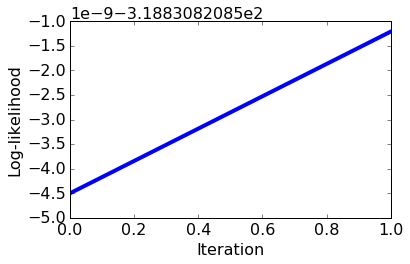

In [133]:
results = EM(data, initial_means, initial_covs, initial_weights)

# YOUR CODE HERE
loglikelihoods = results['loglik']

plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [169]:
images = sframe.SFrame('images.sf/')
images['rgb'] = images.pack_columns(['red', 'green', 'blue'])['X4']

In [170]:
images['rgb'][0]

[0.4032234842076981, 0.2545700932661306, 0.29739183218564663]

In [140]:
np.random.seed(1)

# Initalize parameters
init_means = [images['rgb'][x] for x in np.random.choice(len(images), 4, replace=False)]
cov = np.diag([images['red'].var(), images['green'].var(), images['blue'].var()])
init_covariances = [cov, cov, cov, cov]
init_weights = [1/4., 1/4., 1/4., 1/4.]

# Convert rgb data to numpy arrays
img_data = [np.array(i) for i in images['rgb']]  

# Run our EM algorithm on the image data using the above initializations. 
# This should converge in about 125 iterations
out = EM(img_data, init_means, init_covariances, init_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Iteration 70
Iteration 75
Iteration 80
Iteration 85
Iteration 90
Iteration 95
Iteration 100
Iteration 105
Iteration 110
Iteration 115
Iteration 118


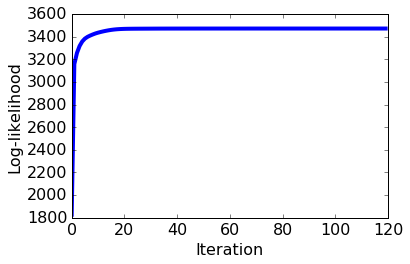

In [141]:
ll = out['loglik']
plt.plot(range(len(ll)),ll,linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

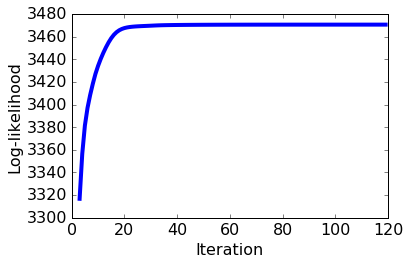

In [142]:
plt.figure()
plt.plot(range(3,len(ll)),ll[3:],linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [143]:
import colorsys
def plot_responsibilities_in_RB(img, resp, title):
    N, K = resp.shape
    
    HSV_tuples = [(x*1.0/K, 0.5, 0.9) for x in range(K)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    
    R = img['red']
    B = img['blue']
    resp_by_img_int = [[resp[n][k] for k in range(K)] for n in range(N)]
    cols = [tuple(np.dot(resp_by_img_int[n], np.array(RGB_tuples))) for n in range(N)]

    plt.figure()
    for n in range(len(R)):
        plt.plot(R[n], B[n], 'o', c=cols[n])
    plt.title(title)
    plt.xlabel('R value')
    plt.ylabel('B value')
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

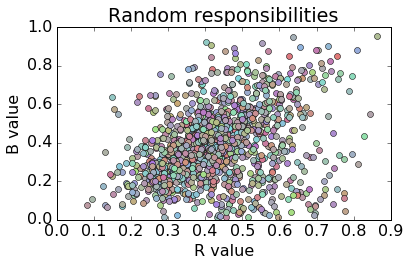

In [144]:
N, K = out['resp'].shape
random_resp = np.random.dirichlet(np.ones(K), N)
plot_responsibilities_in_RB(images, random_resp, 'Random responsibilities')

Iteration 0


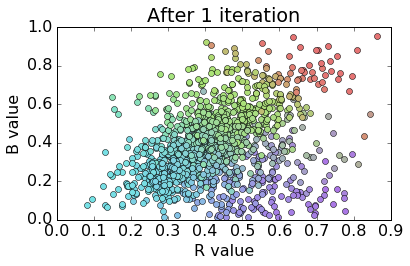

In [146]:
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=1)
plot_responsibilities_in_RB(images, out['resp'], 'After 1 iteration')

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 19


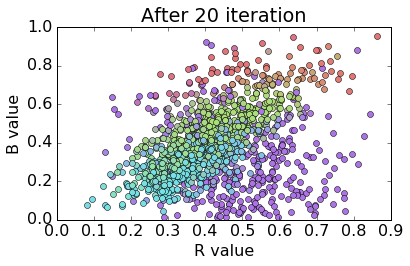

In [148]:
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=20)
plot_responsibilities_in_RB(images, out['resp'], 'After 20 iteration')

In [150]:
images[0]['rgb']

[0.4032234842076981, 0.2545700932661306, 0.29739183218564663]

In [153]:
for i in range(4):
    print multivariate_normal.pdf(images[0]['rgb'],out['means'][i],out['covs'][i])

2.48112744909e-07
2.95757712022e-09
0.331459620105
16.5271595911


In [171]:
means = out['means']
covariances = out['covs']
rgb = images['rgb']
N = len(images)
K = len(means)

assignments = [0]*N
probs = [0]*N

for i in range(N):
    # Compute the score of data point i under each Gaussian component:
    p = np.zeros(K)
    for k in range(K):
        # YOUR CODE HERE (Hint: use multivariate_normal.pdf and rgb[i])
        p[k] = multivariate_normal.pdf(rgb[i],means[k],covariances[k])
        
    # Compute assignments of each data point to a given cluster based on the above scores:
    # YOUR CODE HERE
    assignments[i] = np.argmax(p)
    
    # For data point i, store the corresponding score under this cluster assignment:
    # YOUR CODE HERE
    probs[i] = np.max(p)

assignments = sframe.SFrame({'assignments':assignments, 'probs':probs, 'image': images['image']}).add_row_number('row')

In [172]:
def get_top_images(assignments, cluster, k=5):
    # YOUR CODE HERE
    images_in_cluster = assignments[assignments['assignments'] == cluster]
    top_images = images_in_cluster.topk('probs', k)
    return top_images

In [173]:
get_top_images(assignments,0,k=5).head()

row,assignments,probs,image
591,0,396.449826357,Height: 183 Width: 275
610,0,367.157426627,Height: 194 Width: 259
405,0,359.572953812,Height: 184 Width: 274
427,0,333.211686307,Height: 177 Width: 284
642,0,321.592338562,Height: 194 Width: 259


In [158]:
def display_images(images):
    from IPython.display import display
    
    for image in images:
        display(Image.open(BytesIO(image._image_data)))

def save_images(images, prefix):
    for i, image in enumerate(images):
        Image.open(BytesIO(image._image_data)).save(prefix % i)

Component 0
['Height: 183 Width: 275', 'Height: 194 Width: 259', 'Height: 184 Width: 274', 'Height: 177 Width: 284', 'Height: 194 Width: 259']


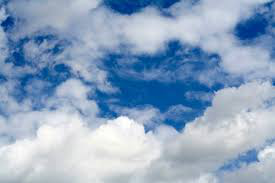

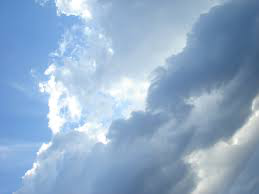

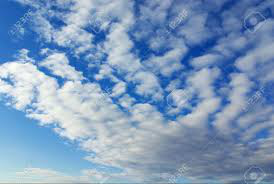

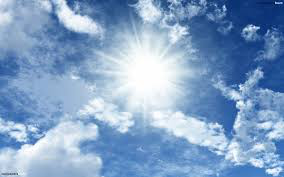

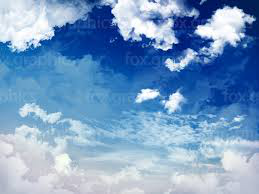



Component 1
['Height: 156 Width: 324', 'Height: 194 Width: 259', 'Height: 183 Width: 275', 'Height: 160 Width: 315', 'Height: 168 Width: 300']


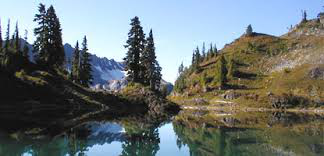

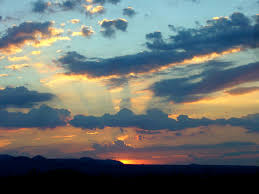

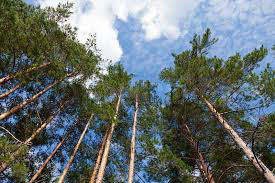

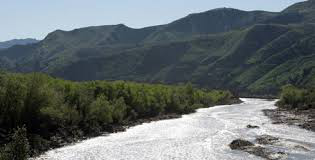

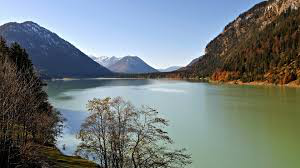



Component 2
['Height: 152 Width: 270', 'Height: 270 Width: 186', 'Height: 168 Width: 300', 'Height: 183 Width: 275', 'Height: 174 Width: 290']


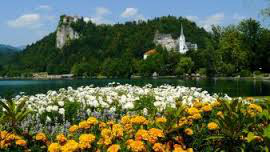

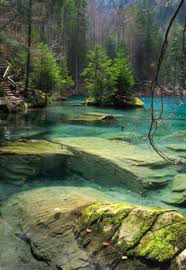

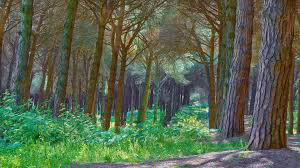

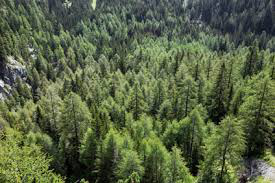

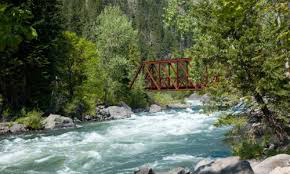



Component 3
['Height: 177 Width: 284', 'Height: 194 Width: 259', 'Height: 183 Width: 275', 'Height: 183 Width: 275', 'Height: 182 Width: 276']


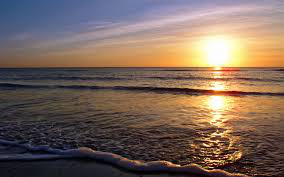

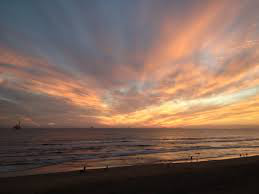

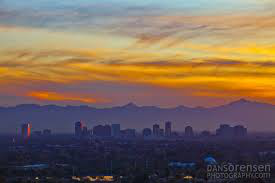

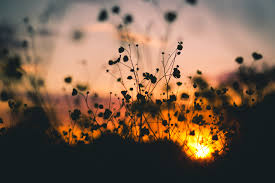

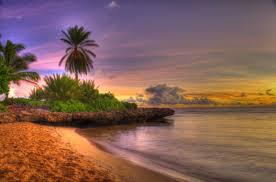

In [164]:
from PIL import Image
from io import BytesIO
for component_id in range(4):
    print 'Component {0:d}'.format(component_id)
    images = get_top_images(assignments, component_id)
    print(images)
    display_images(images)
    #save_images(images, 'component_{0:d}_%d.jpg'.format(component_id))
    print '\n'